<a href="https://colab.research.google.com/github/AnweshaC21/News-Headline-Categotization-Bengali/blob/main/NewsCategorizationBengali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# installing and importing bnltk library

!pip install bnlp_toolkit
from bnlp import BasicTokenizer
from bnlp import NLTKTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus import stopwords
from bnlp.corpus.util import remove_stopwords
from bnlp import BengaliWord2Vec
from bnlp.embedding.fasttext import BengaliFasttext
from bnlp import BengaliGlove
from bnlp import BengaliDoc2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 62.7 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=82e62278afa2431ef425f4bf6000b5be7f7322d3162bc0f04759991b6f41dc77
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


fasttext not installed. Install it by 'pip install fasttext'


In [45]:
# reading data

data = pd.read_excel("/content/gdrive/MyDrive/Datasets/News Headlines.xlsx", usecols=['Title', 'Category'])
data.sample(10)

,Title,Category
274,"উচ্ছেদ করতে গিয়ে বাধার মুখে পুলিশ, মারধর করা হ...",Politics
440,"বৃষ্টি নামতে পারে রাজ্যে, তবে উত্তর ও দক্ষিণবঙ...",Climate/environment
312,"‘কংগ্রেসকে ভোট দিয়েছি, বাসে টিকিট কাটব না’, অন...",Politics
715,পোষ্য কুকুরকে নিয়ে অশান্তি! নাক গলানোয় একত্রবা...,Accident/Crime
151,হঠাৎ বিদায়! মোহনবাগান ছেড়ে চলে গেলেন এই স্প্য...,Sports
61,গুজরাতকে হারিয়ে সমর্থকদের তির জাডেজার! নতুন বি...,Sports
511,এখনই যাচ্ছে না শীত! ৪৮ ঘণ্টায় রাজ্যে আরও কমতে ...,Climate/environment
253,আল আকসা মসজিদ চত্বরে প্যালেস্তেনীয়দের সঙ্গে সং...,Politics
917,কোভিড জয়ের পথ দেখাবে কৃত্রিম মেধা!,Science
216,"জীবন-জীবিকার দাবিতে এক ছাতার তলায় আদিবাসীরা, ন...",Politics


Understanding the data

In [5]:
data.shape

(920, 2)

In [6]:
# listing distinct categories of news

for i in data['Category'].unique():
  print(i)

Sports
Politics
Climate/environment
Accident/Crime
Science


In [7]:
# checking missing values

data.isnull().any()

Title       False
Category    False
dtype: bool

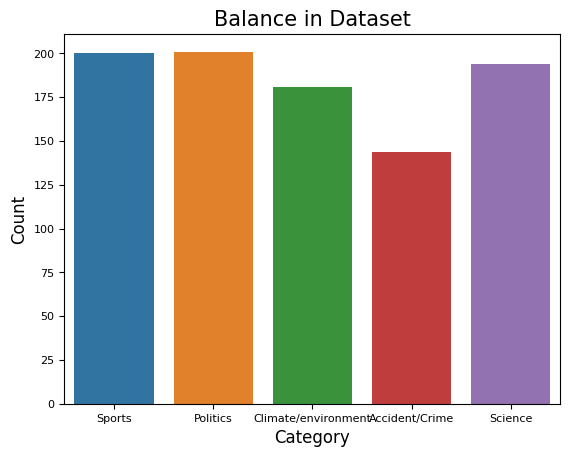

In [42]:
# checking if the data is balanced

p = sns.countplot(data = data, x='Category', saturation=0.75, width=0.8)
p.axes.set_title("Balance in Dataset",fontsize=15)
p.set_xlabel("Category",fontsize=12)
p.set_ylabel("Count",fontsize=12)
p.tick_params(labelsize=8)

In [9]:
# counting length of each headline string

data['News_length'] = data['Title'].str.len()
print(data['News_length'])

0      88
1      80
2      55
3      81
4      54
       ..
915    57
916    78
917    34
918    49
919    74
Name: News_length, Length: 920, dtype: int64


Text(0.5, 1.0, 'Headline Length Distribution')

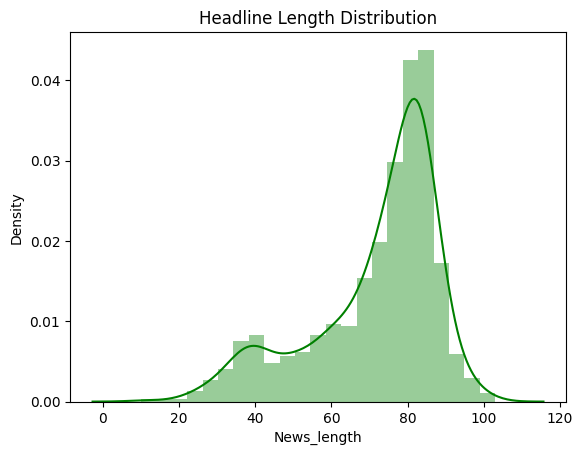

In [34]:
# plotting the distribution of length of headlines

warnings.filterwarnings('ignore')
sns.distplot(data['News_length'], color='green').set_title('Headline Length Distribution')

Pre-processing the data

In [11]:
data['TitleCleaned'] = ''
data['Category_target'] = data['Category']

print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~।ঃ


In [12]:
for i in range(len(data)):
  cleaned = remove_stopwords(data['Title'][i], stopwords)   # removing stop words using bnltk corpus
  for j in cleaned:   # removing punctuations
    if j in punctuations:
      cleaned.remove(j)

  filtered_sentence = []    # join tokens back to form sentence
  for w in cleaned: 
    filtered_sentence.append(w)
  cleaned_sentence = " ".join(filtered_sentence)

  data['TitleCleaned'][i] = cleaned_sentence

In [13]:
# listing distinct categories of news

data['Category_target'].replace(to_replace=['Sports', 'Politics', 'Climate/environment', 'Accident/Crime', 'Science'], value=[0, 1, 2, 3, 4], inplace=True)

In [14]:
data.sample(10)

,Title,Category,News_length,TitleCleaned,Category_target
673,"ব্যারাকপুর নয়, ডাকাতদের প্রথম ‘টার্গেট’ ছিল হা...",Accident/Crime,89,ব্যারাকপুর ডাকাতদের ‘ টার্গেট ’ হাওড়ার গয়নার ...,3
597,মানবাধিকার সংস্থার নাম লেখা বাইকে শিশুকে অপহরণ,Accident/Crime,46,মানবাধিকার সংস্থার নাম লেখা বাইকে শিশুকে অপহরণ,3
100,ধোনিদের বিরুদ্ধে নতুন জার্সি পরে খেলতে নামবে স...,Sports,68,ধোনিদের বিরুদ্ধে জার্সি খেলতে নামবে সৌরভের দিল...,0
400,আসানসোল শিল্পাঞ্চলে ছ’টি কয়লাখনি চালু করার অন...,Politics,72,আসানসোল শিল্পাঞ্চলে ছ ’ কয়লাখনি অনুমোদন দিল র...,1
56,"হার্দিক-ক্রুণাল লড়াই হচ্ছে না, লখনউকে হারিয়ে ...",Sports,82,হার্দিক ক্রুণাল লড়াই লখনউকে হারিয়ে আইপিএলে খে...,0
108,কোহলিদের জয়ে চাপ বাড়ল কলকাতার! এখনও কোন অঙ্কে...,Sports,80,কোহলিদের জয়ে চাপ বাড়ল কলকাতার অঙ্কে প্লে অফে ...,0
632,"মালবোঝাই ট্রাক পিষে দিল মহিলাকে, মেদিনীপুরে বা...",Accident/Crime,78,মালবোঝাই ট্রাক পিষে দিল মহিলাকে মেদিনীপুরে বাই...,3
328,২৭ মে নীতি আয়োগের বৈঠকে দিল্লি যাবেন মুখ্যমন্ত...,Politics,69,২৭ মে নীতি আয়োগের বৈঠকে দিল্লি যাবেন মুখ্যমন্ত...,1
879,রাশিয়া-ইউক্রেন যুদ্ধের জেরে কি আরও অনিশ্চিত হয়...,Science,77,রাশিয়া ইউক্রেন যুদ্ধের জেরে অনিশ্চিত হয়ে পড়ল ...,4
179,রোনাল্ডো ‘প্রতারক’! ক্লাব সভাপতির তোপের জবাব প...,Sports,68,রোনাল্ডো ‘ প্রতারক ’ ক্লাব সভাপতির তোপের জবাব ...,0


Split the data in training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data['Title'], 
                                                    data['Category_target'], 
                                                    test_size=0.2, 
                                                    random_state=8)

In [16]:
ngram_range = (1,2)

TF-IDF Vectorization

In [17]:
tfidf = TfidfVectorizer(ngram_range=ngram_range,use_idf=True,tokenizer=lambda x: x.split()) 
X = tfidf.fit_transform(data['Title'])

In [18]:
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train)
print(features_train.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(736, 10828)


In [19]:
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test)
print(features_test.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(184, 10828)


Applying ML Models

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [69]:
accuracy = {}

Random Forest

In [27]:
model  = RandomForestClassifier(random_state=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.6684782608695652
              precision    recall  f1-score   support

           0       0.84      0.51      0.64        41
           1       0.42      0.93      0.58        41
           2       0.95      0.70      0.81        27
           3       0.87      0.65      0.74        31
           4       1.00      0.57      0.72        44

    accuracy                           0.67       184
   macro avg       0.82      0.67      0.70       184
weighted avg       0.81      0.67      0.69       184



In [28]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [29]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(features_train, labels_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


In [30]:
bestF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [31]:
model1  = RandomForestClassifier(random_state=1,max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)
model1.fit(features_train, labels_train)
model_predictions = model1.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.7391304347826086
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        41
           1       0.49      0.93      0.64        41
           2       0.95      0.74      0.83        27
           3       0.91      0.68      0.78        31
           4       1.00      0.61      0.76        44

    accuracy                           0.74       184
   macro avg       0.84      0.74      0.76       184
weighted avg       0.83      0.74      0.75       184



In [70]:
#accuracy.append(accuracy_score(labels_test, model_predictions))
accuracy['Random Forest'] = 0.7391304347826086

Logistic Regression

In [91]:
model = LogisticRegression()
print(model.get_params())
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.8804347826086957
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        41
           1       0.79      0.93      0.85        41
           2       0.89      0.89      0.89        27
           3       0.92      0.71      0.80        31
           4       0.93      0.89      0.91        44

    accuracy                           0.88       184
   macro avg       0.89      0.87      0.88       184
weighted avg       0.89      0.88      0.88       184



In [72]:
accuracy['Logistic Regression'] = accuracy_score(labels_test, model_predictions)

KNN

In [74]:
model = KNeighborsClassifier()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.782608695652174
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        41
           1       0.74      0.68      0.71        41
           2       0.67      0.89      0.76        27
           3       0.89      0.77      0.83        31
           4       0.86      0.68      0.76        44

    accuracy                           0.78       184
   macro avg       0.79      0.79      0.78       184
weighted avg       0.79      0.78      0.78       184



In [75]:
accuracy['KNN'] = accuracy_score(labels_test, model_predictions)

Decision Tree

In [76]:
model = DecisionTreeClassifier(random_state=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.6521739130434783
              precision    recall  f1-score   support

           0       0.73      0.54      0.62        41
           1       0.45      0.59      0.51        41
           2       0.71      0.74      0.73        27
           3       0.72      0.74      0.73        31
           4       0.76      0.70      0.73        44

    accuracy                           0.65       184
   macro avg       0.68      0.66      0.66       184
weighted avg       0.67      0.65      0.66       184



In [77]:
accuracy['Decision Tree'] = accuracy_score(labels_test, model_predictions)

In [78]:
accuracy

{'Random Forest': 0.7391304347826086,
 'Logistic Regression': 0.8804347826086957,
 'KNN': 0.782608695652174,
 'Decision Tree': 0.6521739130434783}

Plotting accuracy

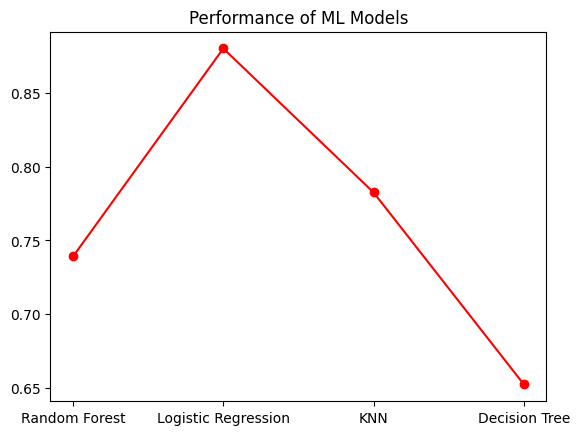

In [90]:
x = accuracy.keys()
y = accuracy.values()
plt.plot(x, y, marker='o', c='r')

plt.title('Performance of ML Models')
plt.show()

Testing with unseen headlines

In [153]:
unseen_data = ['আইপিএল ফাইনাল শুরু হবে, ১৫ ওভারের খেলা, জিততে গেলে কত তুলতে হবে ধোনিদের?',    # IPL/Final
               'আইপিএল ফাইনাল সুপার ওভারে গড়ালে ক’টার মধ্যে শুরু করতে হবে, নিয়ম কী?',     # IPL/Final
               'দক্ষিণে ঊর্ধ্বমুখী পারদ, পশ্চিমের জেলায় তাপমাত্রা পৌঁছতে পারে ৪০ ডিগ্রির আশপাশে, বৃষ্টি কি হবে?',   # Weather Forecast
               'দূষণ রোধে রেলকে চিঠি দেবে পর্ষদ',   # Pollution
               'জম্মু-কাশ্মীরে আবার খুন! হাসপাতালের সামনেই সার্কাসকর্মীকে গুলি করে হত্যা করল জঙ্গিরা',    # Murder/gunshots
               'কর্নাটক জয়ে উজ্জীবিত কংগ্রেস, মধ্যপ্রদেশে কত আসন পাবে দল? বৈঠক শেষে কী দাবি রাহুলের']   # Karnataka/Congress

In [154]:
for i in range(len(unseen_data)):
  cleaned = remove_stopwords(unseen_data[i], stopwords)   # removing stop words using bnltk corpus
  for j in cleaned:   # removing punctuations
    if j in punctuations:
      cleaned.remove(j)

  filtered_sentence = []    # join tokens back to form sentence
  for w in cleaned: 
    filtered_sentence.append(w)
  cleaned_sentence = " ".join(filtered_sentence)

  unseen_data[i] = cleaned_sentence

In [155]:
features_unseen = tfidf.transform(unseen_data).toarray()

In [156]:
model.predict(features_unseen)

array([0, 0, 2, 2, 3, 1])

0 - Sports; 1 - Politics; 2 - Climate/Environment; 3 - Accident/Crime; 4 - Science

Confusion

In [179]:
data1 = ['বিজেপি নেত্রীকে পাথর মেরে খুন! পালাগানের পেশাদার শিল্পীও ছিলেন তিনি',    # BJP/murder
         'বৃষ্টিতে বন্ধ খেলা!',    # rain/match 
         'ভ্রমণ ইতিহাস সাহিত্য মহাকাব্যের আঙিনায়']   # travel/history/literature/epic

In [180]:
for i in range(len(data1)):
  cleaned = remove_stopwords(data1[i], stopwords)   # removing stop words using bnltk corpus
  for j in cleaned:   # removing punctuations
    if j in punctuations:
      cleaned.remove(j)

  filtered_sentence = []    # join tokens back to form sentence
  for w in cleaned: 
    filtered_sentence.append(w)
  cleaned_sentence = " ".join(filtered_sentence)

  data1[i] = cleaned_sentence

  features_1 = tfidf.transform(data1).toarray()

In [181]:
model.predict(features_1)

array([1, 2, 4])